<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

Collection:

In [16]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
attack_type_counts = cicids2017_df['Attack Type'].value_counts()
print(attack_type_counts)

# Calculate and print total benign and malicious samples
total_benign = attack_type_counts.get('Normal Traffic', 0)
total_malicious = attack_type_counts.sum() - total_benign

print(f"\nTotal Benign Samples: {total_benign}")
print(f"Total Malicious Samples: {total_malicious}")


# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {type: i for i, type in enumerate(attack_types)}

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Total Benign Samples: 2095057
Total Malicious Samples: 425694

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Separate Benign and Malicious Traffic ---

# Separate benign and malicious samples
benign_df = cicids2017_df[cicids2017_df['Attack Type'] == 0]
malicious_df = cicids2017_df[cicids2017_df['Attack Type'] != 0]

# Separate features (X) and labels (y) for benign data
X_benign = benign_df.drop('Attack Type', axis=1)
y_benign = benign_df['Attack Type']

# Separate features (X) and labels (y) for malicious data
X_malicious = malicious_df.drop('Attack Type', axis=1)
y_malicious = malicious_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X_benign, y_benign, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Create test set
X_test = pd.concat([X_test, X_malicious], ignore_index=True)
y_test = pd.concat([y_test, y_malicious], ignore_index=True)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Visualise Split

Input Shapes -> Train: (1340836, 52), Val: (335209, 52), Test: (844706, 52)
Labels distribution -> Train: [1340836       0       0       0       0       0       0], Val: [335209      0      0      0      0      0      0], Test: [419012  90694   2143   9150 128014   1948 193745]


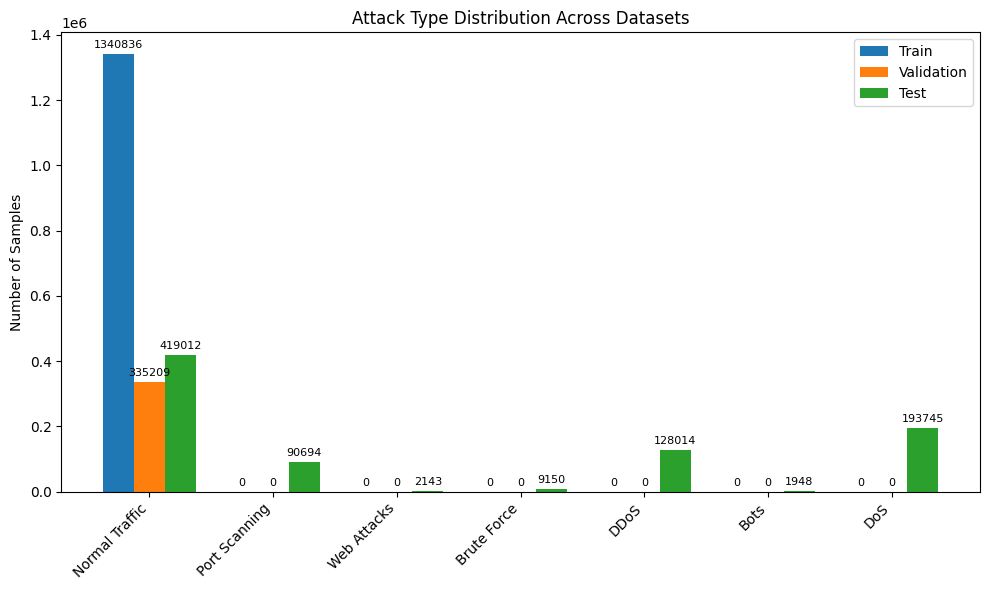

In [18]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

Normalise the data:

In [19]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
# Initialize the scaler
#scaler = RobustScaler()
scaler = StandardScaler()

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")



Shape of X_train after scaling: (1340836, 52)
Shape of X_val after scaling: (335209, 52)
Shape of X_test after scaling: (844706, 52)


Visualise Benign data: (TEST)

/tmp/ipython-input-1423721660.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


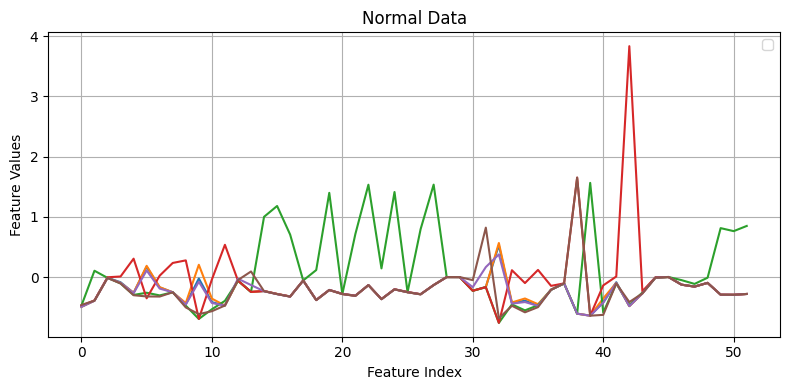

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(X_train[0])
plt.plot(X_train[2])
plt.plot(X_train[3])
plt.plot(X_train[4])
plt.plot(X_train[5])
plt.plot(X_train[6])
plt.title("Normal Data")
plt.xlabel('Feature Index')
plt.ylabel('Feature Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 4))
# plt.plot(X_train)
# plt.title("Normal Data")
# plt.xlabel('Feature Index')
# plt.ylabel('Feature Values')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#Autoencoder model
An autoencoder model consists of two parts:
- **Encoder**: Responsible for compressing the input data into a lower-dimensional representation of the input data that captures the most important information.
- **Decoder**: Responsible for reconstructing the input data from the latent space representation. The decoder takes the latent space representation as input and produces a reconstructed version of the input data as output. The reconstructed data should be as similar as possible to the original input data.

- Advantages of autoencoders: Can be used to detect anomalies, unsupervised learning models (they do not require labeled data in training), easy to train and implement.
- Disadvantages of autoencoders: computationally expensive to train (especially for large datasets.), they are sensitive to the choice of hyperparameters, difficult to interpret.

Below is a simple autoencoder model with three layers in the encoder and three layers in the decoder. https://levelup.gitconnected.com/build-deep-autoencoders-model-for-anomaly-detection-in-python-a-complete-guide-a7d0ec0e688
https://medium.com/@ndhilani.simbine/how-i-built-a-real-time-anomaly-detection-system-for-enterprise-networks-using-python-and-machine-0078d8a26e84
https://medium.com/@walid.daboubi/malware-detection-using-deep-autoencoder-neural-network-wannacry-as-a-test-9d0125c925b2

In [21]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
import numpy as np # Import numpy

# Determine the input dimension from the scaled training data
autoencoder_input_dim = X_train.shape[1]
print(f"Autoencoder input dimension: {autoencoder_input_dim}")

autoencoder = Sequential([
    Input(shape=(autoencoder_input_dim,)),
    Dense(64, activation='relu'),                             # Encoder layer
    Dense(32, activation='relu'),                             # Encoder layer
    Dense(16, activation='relu'),                             # Encoder bottleneck
    Dense(32, activation='relu'),                             # Decoder layer
    Dense(64, activation='relu'),                             # Decoder layer
    Dense(autoencoder_input_dim, activation='linear')   #'sigmoid'                 # Output layer (same size as input)
])

autoencoder.compile(optimizer='adam', loss='mse')

Autoencoder input dimension: 52


# Train and test the model

Epoch 1/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 0.1995 - val_loss: 0.1955
Epoch 2/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 0.0830 - val_loss: 0.1342
Epoch 3/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0724 - val_loss: 0.0542
Epoch 4/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - loss: 0.0503 - val_loss: 0.0547
Epoch 5/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - loss: 0.0469 - val_loss: 0.2077
Epoch 6/10
20951/20951 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - loss: 0.0495 - val_loss: 0.0894
Training time: 468.22 seconds


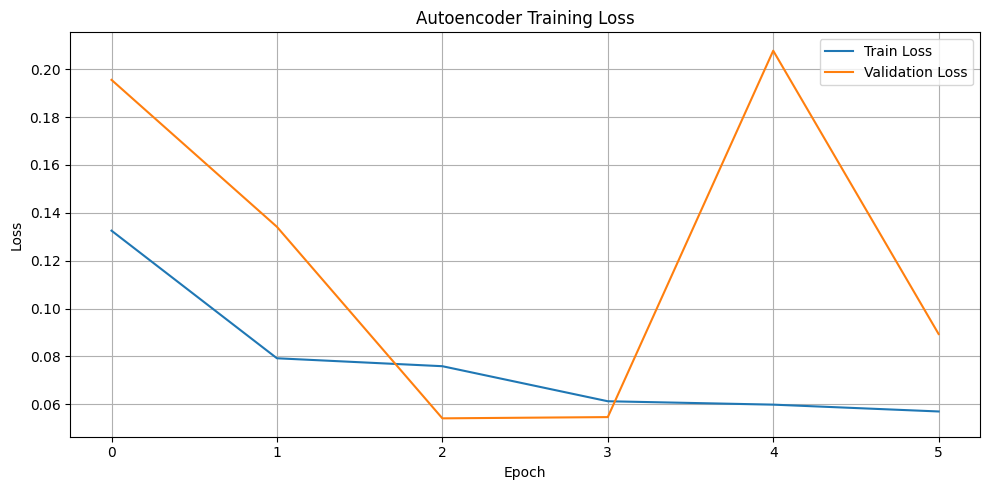

In [22]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    verbose=1
)


# End timing
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot training and validation loss graph
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#Test the model

Establish the threshold

In [23]:
import tensorflow as tf
import numpy as np

# --- Getting Threshold ----
# Get reconstructions and reconstruction errors of the training data
print("Getting average reconstruction error from the training data to determine a threshold...")
training_reconstructions = autoencoder.predict(X_train, verbose=0) # Added verbose=0 to reduce output during prediction

#TESTING:
#training_reconstruction_errors = np.sum(np.square(reconstructions - X_test), axis=1)# Calculate the sum of reconstruction error for each feature for each sample in the training dataset.
training_reconstruction_errors = np.mean(np.square(training_reconstructions - X_train), axis=1)

# Inspect first row
np.set_printoptions(precision=4, suppress=True)
print("original training data (first row):\n", X_train[:1])
print("training_reconstructions (first row):\n", training_reconstructions[:1])
print("training_reconstruction_errors (first row):\n", training_reconstruction_errors[:1])

# Set the threshold -> Taking the average sum of reconstruction errors
threshold = np.mean(training_reconstruction_errors) #+ np.std(train_loss) # Choosing a threshold value that is one standard deviations above the mean.
# threshold = np.percentile(training_reconstruction_errors, 95)

print(f"Threshold value: {threshold}")


Getting average reconstruction error from the training data to determine a threshold...
original training data (first row):
 [[-0.4917 -0.3889 -0.0087 -0.0839 -0.2604  0.1732 -0.1701 -0.2501 -0.4493
  -0.0221 -0.4142 -0.4701 -0.0574 -0.2437 -0.2309 -0.2792 -0.3205 -0.0551
  -0.3793 -0.2118 -0.2759 -0.3071 -0.1314 -0.3647 -0.2018 -0.2487 -0.2838
  -0.1309  0.0022  0.0019 -0.2246 -0.1627  0.5296 -0.4346 -0.3881 -0.477
  -0.2084 -0.1029 -0.6051 -0.6389 -0.4191 -0.0839 -0.4802 -0.2691 -0.0051
   0.0031 -0.1239 -0.1562 -0.0944 -0.2903 -0.2918 -0.2783]]
training_reconstructions (first row):
 [[-0.496  -0.4002 -0.0039 -0.1265 -0.2691  0.1973 -0.167  -0.2592 -0.431
  -0.0105 -0.4139 -0.4521 -0.043  -0.2496 -0.2333 -0.2663 -0.2957 -0.0615
  -0.3863 -0.2175 -0.2709 -0.2797 -0.1262 -0.3609 -0.2013 -0.2688 -0.2707
  -0.1222  0.04    0.0265 -0.247  -0.0996  0.5189 -0.4242 -0.3972 -0.4632
  -0.1959 -0.081  -0.5851 -0.6193 -0.387  -0.1234 -0.4983 -0.2804 -0.0211
   0.0174 -0.1275 -0.1613 -0.1183 -0.2

Test the model on the test dataset

In [24]:
import tensorflow as tf
import numpy as np

# Get reconstructions and errors for test data
test_reconstructions = autoencoder.predict(X_test)

#TESTING
#test_reconstruction_errors = np.sum(np.square(test_reconstructions - X_test), axis=1)
test_reconstruction_errors = np.mean(np.square(test_reconstructions - X_test), axis=1) # Reconstruction error: Mean Squared Error per sample

# Display first row of data
np.set_printoptions(precision=4, suppress=True)
print("Original test data (first row):\n", X_test[0])
print("\nReconstructed test data (first row):\n", test_reconstructions[0])
print("\n Average Reconstruction error (first row):\n", test_reconstruction_errors[0])

# Identify anomalies (1 or 0)
y_pred = (test_reconstruction_errors > threshold).astype(int)
traffic_anomalies = np.where(y_pred == 1)[0]


26398/26398 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Original test data (first row):
 [-0.4903 -0.3851 -0.0099 -0.1009 -0.2774 -0.3503 -0.2897 -0.2184  4.7129
 -0.6929  6.0295  6.5573 -0.0552 -0.2444 -0.2275 -0.2723 -0.3124 -0.0551
 -0.3804 -0.2128 -0.2798 -0.3094 -0.1314 -0.3597 -0.1987 -0.2338 -0.2736
 -0.1309  0.0022  0.0019 -0.225  -0.1646 -0.7582  3.4655  5.4363  5.1573
  5.1215 -0.1029  1.6527 -0.6389  5.7294 -0.1009  0.0592 -0.2454 -0.0066
  0.0031 -0.1239 -0.1562 -0.0944 -0.2903 -0.2918 -0.2783]

Reconstructed test data (first row):
 [-0.6075 -0.441   0.2854  1.0602  0.3307 -0.5847 -0.0417  0.1086  5.5998
 -0.912   6.0752  5.0429 -0.1026 -0.3352 -0.2307 -0.2167 -0.3401 -0.1514
 -0.4422 -0.3064  0.0415 -0.4089 -0.276  -0.2635 -0.0692 -0.0068 -0.2186
  0.014   0.0703 -0.0615 -0.3332 -0.1206 -0.821   3.9461  4.9986  3.9792
  2.8113 -0.0154  2.0699 -0.8802  4.7835  1.1134 -0.1312 -0.4202  0.2699
 -0.0532  0.1192  0.0935 -0.0854 -0.179  -0.3857 -0.0994]

 Average Reconstruction error (firs

# Evaluate model predictions against ground truth

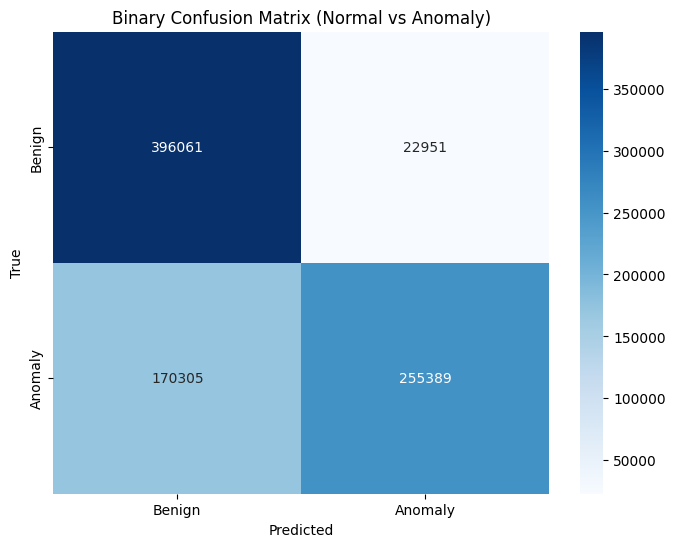


Accuracy:
sklearn Accuracy: 0.7712150736469257

Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.95      0.80    419012
     Anomaly       0.92      0.60      0.73    425694

    accuracy                           0.77    844706
   macro avg       0.81      0.77      0.76    844706
weighted avg       0.81      0.77      0.76    844706


Anomaly Detection Metrics:
True Positives (Anomalies correctly detected): 255389
True Negatives (Normal Traffic correctly identified): 396061
False Positives (Normal Traffic misclassified as Anomaly): 22951
False Negatives (Anomalies missed): 170305

Percentage of Anomalies Detected: 59.99%
Percentage of Normal Traffic Misclassified (False Positive Rate): 5.48%


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test to binary: 0 = Normal, 1 = Anomaly
y_test_binary = (y_test != 0).astype(int)

# --- Confusion matrix ---
cm = confusion_matrix(y_test_binary, y_pred)

# --- Heatmap ---
# Labels for the binary confusion matrix
binary_labels = ['Benign', 'Anomaly']

# Plot heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
plt.title("Binary Confusion Matrix (Normal vs Anomaly)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test_binary, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names for binary classification
report = classification_report(y_test_binary, y_pred, target_names=binary_labels, output_dict=True)
print(classification_report(y_test_binary, y_pred, target_names=binary_labels))

# --- Custom Metrics for Anomaly Detection ---
# From the confusion matrix:
tn, fp, fn, tp = cm.ravel() # Unpack confusion matrix values

print("\nAnomaly Detection Metrics:")
print(f"True Positives (Anomalies correctly detected): {tp}")
print(f"True Negatives (Normal Traffic correctly identified): {tn}")
print(f"False Positives (Normal Traffic misclassified as Anomaly): {fp}")
print(f"False Negatives (Anomalies missed): {fn}")

# Calculate percentages
total_anomalies = tp + fn
total_normal = tn + fp

percentage_anomalies_detected = (tp / total_anomalies) * 100 if total_anomalies > 0 else 0
percentage_normal_misclassified = (fp / total_normal) * 100 if total_normal > 0 else 0

print(f"\nPercentage of Anomalies Detected: {percentage_anomalies_detected:.2f}%")
print(f"Percentage of Normal Traffic Misclassified (False Positive Rate): {percentage_normal_misclassified:.2f}%")

# Input Vs Reconstructed Output

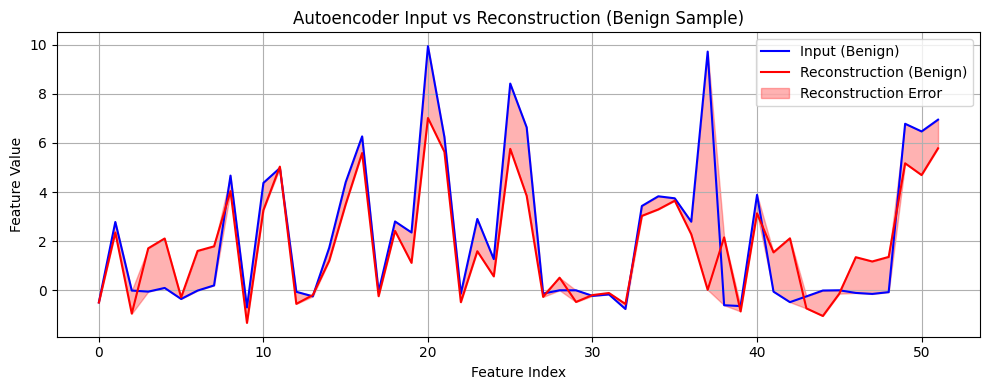

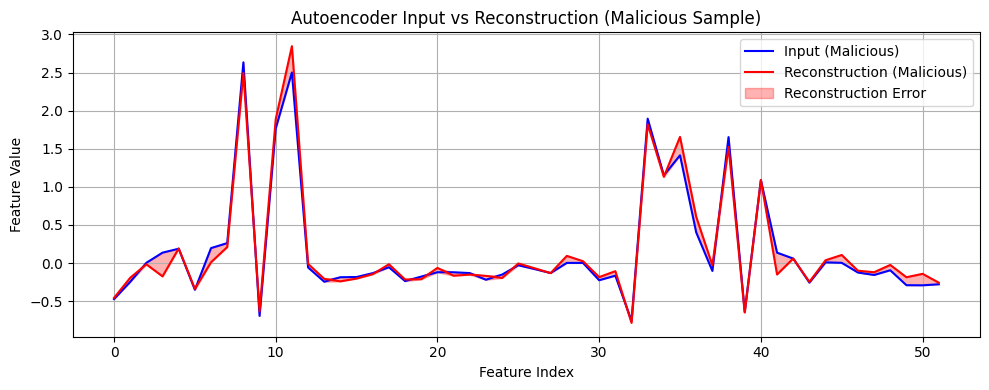

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Find the index of a benign and a malicious sample in the test set
benign_sample_indices = y_test[y_test == 0].index
malicious_sample_indices = y_test[y_test != 0].index


# Ensure there are benign and malicious samples in the test set before proceeding
if len(benign_sample_indices) > 0:
    benign_sample_idx_in_test_set = benign_sample_indices[0] # Get the first benign sample indice from the test set
else:
    benign_sample_idx_in_test_set = None
    print("No benign samples found in the test set.")

if len(malicious_sample_indices) > 0:
    malicious_sample_idx_in_test_set = malicious_sample_indices[0] # Get the first malicious sample indice from the test set
else:
    malicious_sample_idx_in_test_set = None
    print("No malicious samples found in the test set.")


# --- Plot Benign Sample ---
if benign_sample_idx_in_test_set is not None:
    input_sample_benign = X_test[benign_sample_idx_in_test_set]
    reconstructed_sample_benign = test_reconstructions[benign_sample_idx_in_test_set]

    plt.figure(figsize=(10, 4))
    plt.plot(input_sample_benign, label='Input (Benign)', color='blue')
    plt.plot(reconstructed_sample_benign, label='Reconstruction (Benign)', color='red')

    # Fill in error gap
    plt.fill_between(np.arange(len(input_sample_benign)),
                     np.minimum(input_sample_benign, reconstructed_sample_benign),
                     np.maximum(input_sample_benign, reconstructed_sample_benign),
                     color='red', alpha=0.3, label='Reconstruction Error')

    plt.legend()
    plt.title("Autoencoder Input vs Reconstruction (Benign Sample)")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot Malicious Sample ---
if malicious_sample_idx_in_test_set is not None:
    input_sample_malicious = X_test[malicious_sample_idx_in_test_set]
    reconstructed_sample_malicious = test_reconstructions[malicious_sample_idx_in_test_set]

    plt.figure(figsize=(10, 4))
    plt.plot(input_sample_malicious, label='Input (Malicious)', color='blue')
    plt.plot(reconstructed_sample_malicious, label='Reconstruction (Malicious)', color='red')

    # Error band
    plt.fill_between(np.arange(len(input_sample_malicious)),
                     np.minimum(input_sample_malicious, reconstructed_sample_malicious),
                     np.maximum(input_sample_malicious, reconstructed_sample_malicious),
                     color='red', alpha=0.3, label='Reconstruction Error')

    plt.legend()
    plt.title("Autoencoder Input vs Reconstruction (Malicious Sample)")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Malware Classifier


*   Softmax classifier
*   XGBoost
*   CNN?


In [27]:
# import numpy as np

# class SoftmaxClassifier:
#     def __init__(self, input_dim, num_classes, learning_rate=0.01):
#         self.input_dim = input_dim
#         self.num_classes = num_classes
#         self.learning_rate = learning_rate
#         self.weights = np.random.randn(input_dim, num_classes) * 0.01
#         self.bias = np.zeros((1, num_classes))

#     def softmax(self, z):
#         exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
#         return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

#     def cross_entropy_loss(self, y_true, y_pred):
#         m = y_true.shape[0]
#         log_likelihood = -np.log(y_pred[range(m), y_true])
#         loss = np.sum(log_likelihood) / m
#         return loss

#     def one_hot(self, y):
#         one_hot_labels = np.zeros((y.size, self.num_classes))
#         one_hot_labels[np.arange(y.size), y] = 1
#         return one_hot_labels

#     def train(self, X, y, epochs=100):
#         m = X.shape[0]
#         for epoch in range(epochs):
#             # Forward pass
#             logits = np.dot(X, self.weights) + self.bias
#             probs = self.softmax(logits)

#             # Loss (optional print)
#             loss = self.cross_entropy_loss(y, probs)
#             if epoch % 10 == 0:
#                 print(f"Epoch {epoch}: Loss = {loss:.4f}")

#             # Backpropagation
#             y_one_hot = self.one_hot(y)
#             gradient_logits = (probs - y_one_hot) / m

#             grad_weights = np.dot(X.T, gradient_logits)
#             grad_bias = np.sum(gradient_logits, axis=0, keepdims=True)

#             # Gradient descent update
#             self.weights -= self.learning_rate * grad_weights
#             self.bias -= self.learning_rate * grad_bias

#     def predict(self, X):
#         logits = np.dot(X, self.weights) + self.bias
#         probs = self.softmax(logits)
#         return np.argmax(probs, axis=1)


Get data for classiifer training

Training the Classifier

In [28]:
# input_dim = X_train_malware.shape[1]
# num_classes = len(np.unique(y_train_malware))

# classifier = SoftmaxClassifier(input_dim=input_dim, num_classes=num_classes)
# classifier.train(X_train_malware, y_train_malware, epochs=10)


Predicting Malware Class for Anomalies

In [29]:
# y_pred_classes = classifier.predict(X_anomalies)

# # Optionally evaluate
# from sklearn.metrics import classification_report
# print(classification_report(y_anomalies, y_pred_classes))
